In [1]:
import pandas as pd

train = pd.read_csv('hgt.csv')
train.info()

FileNotFoundError: File b'hgt.csv' does not exist

In [ ]:
import pandas as pd

y = [1,2,3]
y_pre1 = pd.DataFrame(y)
y_pre = pd.DataFrame({"label": y})
print(y_pre)
print(y_pre1)

In [ ]:
fit_params = {"eval_metric": "rmse"}
print(fit_params)

**不同参数下XGBoost预测台风的准确度**

No.|learning_rate|n_estimators|max_depth|train_score|test_score
-|:-:|:-:|:-:|:-:|-:
1|0.2|500|16|0.387|0.036
2|0.2|500|8|0.387|0.036
3|0.2|500|3|0.151|0.192
4|0.2|400|16|0.387|0.036
5|0.2|400|8|0.387|0.036
6|0.2|400|3|0.151|0.192
7|0.1|500|16|0.440|0.301
8|0.1|500|8|0.440|0.301
9|0.1|500|3|0.470|0.426
10|0.1|400|16|0.440|0.301
11|0.1|400|8|0.440|0.301
12|0.1|400|3|0.470|0.426


输入数据类型： (50, 498)
标签类型： (50,)


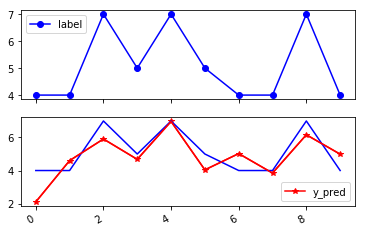

saving model
训练结果 0.47070193524748993
Parameter optimization
Fitting 2 folds for each of 150 candidates, totalling 300 fits


/home/yu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:584: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.2min finished


Best: 0.202999 using {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 50}
-7.845481 (0.651357) with: {'learning_rate': 0.0001, 'max_depth': 2, 'n_estimators': 50}
-7.782726 (0.655528) with: {'learning_rate': 0.0001, 'max_depth': 2, 'n_estimators': 100}
-7.658916 (0.663653) with: {'learning_rate': 0.0001, 'max_depth': 2, 'n_estimators': 200}
-7.410112 (0.677539) with: {'learning_rate': 0.0001, 'max_depth': 2, 'n_estimators': 400}
-7.279675 (0.677810) with: {'learning_rate': 0.0001, 'max_depth': 2, 'n_estimators': 500}
-7.845481 (0.651357) with: {'learning_rate': 0.0001, 'max_depth': 4, 'n_estimators': 50}
-7.782726 (0.655528) with: {'learning_rate': 0.0001, 'max_depth': 4, 'n_estimators': 100}
-7.658916 (0.663653) with: {'learning_rate': 0.0001, 'max_depth': 4, 'n_estimators': 200}
-7.410112 (0.677539) with: {'learning_rate': 0.0001, 'max_depth': 4, 'n_estimators': 400}
-7.279675 (0.677810) with: {'learning_rate': 0.0001, 'max_depth': 4, 'n_estimators': 500}
-7.845481 (0.651357) w

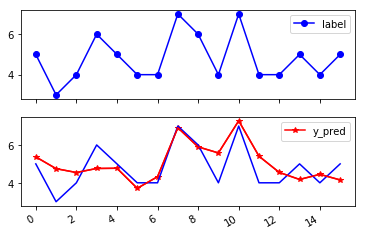

测试结果： 0.4260412462170958


In [20]:
import pandas as pd
import numpy as np
from sklearn import metrics
import pickle
from xgboost.sklearn import XGBRegressor
from sklearn.preprocessing import StandardScaler
# from clean_data import prep_water_data,normalize_water_data,normalize_data,delete_null_date
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit


def GDBTTrain(X, y):
	train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=0)  ##test_size测试集合所占比例
	test_preds = pd.DataFrame({"label": test_y})
	clf = XGBRegressor(
		learning_rate=0.1,  # 默认0.3
		n_estimators=400,  # 树的个数
		max_depth=3,
	)
	clf.fit(train_x, train_y)
	test_preds['y_pred'] = clf.predict(test_x)
	stdm = metrics.r2_score(test_preds['label'], test_preds['y_pred'])
	
	import matplotlib.pyplot as plt  # 画出预测结果图
	p = test_preds[['label', 'y_pred']].plot(subplots=True, style=['b-o', 'r-*'])
	plt.plot(test_preds['label'], c='blue')
	plt.plot(test_preds['y_pred'], c='red')
	plt.show()
	
	return stdm, clf


def GDBTest(X, y, clf):
	test_preds = pd.DataFrame({"label": y})
	test_preds['y_pred'] = clf.predict(X)
	# print(test_preds)
	stdm = metrics.r2_score(test_preds['label'], test_preds['y_pred'])
	import matplotlib.pyplot as plt  # 画出预测结果图
	p = test_preds[['label', 'y_pred']].plot(subplots=True, style=['b-o', 'r-*'])
	plt.plot(test_preds['label'], c='blue')
	plt.plot(test_preds['y_pred'], c='red')
	plt.show()
	return stdm


def XGTSearch(X, y):
	print("Parameter optimization")
	n_estimators = [50, 100, 200, 400, 500]
	max_depth = [2, 4, 6, 8, 16]
	learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
	param_grid = dict(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate)
	xgb_model = XGBRegressor()
	kfold = TimeSeriesSplit(n_splits=2).get_n_splits([X, y])
	fit_params = {"eval_metric": "rmse"}
	grid_search = GridSearchCV(xgb_model, param_grid, verbose=1, fit_params=fit_params, cv=kfold)
	grid_result = grid_search.fit(X, y)
	# summarize results
	print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
	means = grid_result.cv_results_['mean_test_score']
	stds = grid_result.cv_results_['std_test_score']
	params = grid_result.cv_results_['params']
	for mean, stdev, param in zip(means, stds, params):
		print("%f (%f) with: %r" % (mean, stdev, param))
	
	return means, grid_result


if __name__ == "__main__":
	X_data_train = pd.read_csv('X_50.csv', encoding="gb18030")
	Y_data_train = pd.read_csv('Y_50.csv', encoding="gb18030")
	Y_data_train = Y_data_train['times']
	out = 'frazee'
	print("输入数据类型：", X_data_train.shape)
	print("标签类型：", Y_data_train.shape)
	X = X_data_train.as_matrix()
	y = Y_data_train.as_matrix()
	stdm, clf = GDBTTrain(X, y)
	print('saving model')
	path = './model/' + out + '_xgb.pkl'
	with open(path, "wb") as f:
		pickle.dump(clf, f)
	print("训练结果", stdm)
	a,b = XGTSearch(X, y)
	X_data_test = pd.read_csv('X_16.csv', encoding="gb18030")
	Y_data_test = pd.read_csv('Y_16.csv', encoding="gb18030")
	Y_data_test = Y_data_test['times']
	
	X = X_data_test.as_matrix()
	y = Y_data_test.as_matrix()
	path = './model/' + out + '_xgb.pkl'
	with open(path, 'rb') as f:
		model = pickle.load(f)
		stdm = GDBTest(X, y, model)
		print("测试结果：", stdm)
  